# STEPOUT model EXTRAPOLATION

In [1]:
import os, sys
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c as c_light
from scipy.signal import find_peaks
from wakis import WakeSolver

sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm

from Extrapolation_benchmarking import *

%matplotlib ipympl

In [2]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/wrong_param_cond_100c.txt"
charge_dist = np.loadtxt(file_path_charge_distance)/100

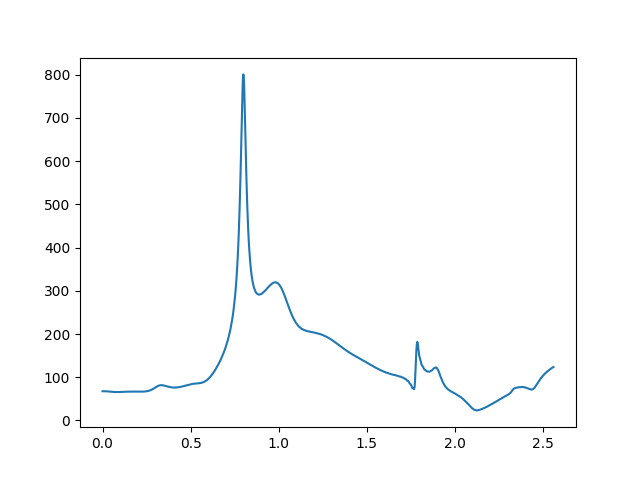

In [3]:
# import impedance data to assess:

imp_data = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/cond_1e3i.txt', comments='#', delimiter='\t')

plt.plot(imp_data[:,0], np.abs(imp_data[:,1]+1j*imp_data[:,2]))
plt.show()

#### Functions for extrapolation evaluation

In [ ]:
def x_attenuation_data(wake_data, energy_data, attenuation):
    minus_x_db_time = energy_data[np.argmax(energy_data[30:, 1] < attenuation) + 30, 0]
    return np.argmax(wake_data[:, 0] > (minus_x_db_time*1e-9 * c_light * 1e2))

In [6]:
def impedance_at_attenuations(attenuations_list, wake_data, energy_data, peak_threshold=1e3):
    row_indices = {}
    for attenuation in attenuations_list:
        row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(wake_data, energy_data, attenuation)

    impedances_attenuations = row_indices.copy()

    fig, axes = plt.subplots(2, 4, figsize=(16, 9))

    for idx, (key, value) in enumerate(row_indices.items()):
        if key != 'key':  # Skip the 'key' entry
            row = idx // 4
            col = idx % 4
            wake = WakeSolver(q=1e-9, sigmaz=0.04)
            wake.WP = wake_data[:value, 1]
            wake.s = wake_data[:value, 0] / 100  # Converting from cm to m
            wake.calc_lambdas_analytic()
            wake.calc_long_Z(samples=1001)
            peaks, peaks_height = find_peaks(np.abs(wake.Z), height=peak_threshold, threshold=None)

            axes[row, col].plot(wake.f, np.abs(wake.Z))
            axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
            axes[row, col].set_xlabel('Frequency [Hz]')
            axes[row, col].set_ylabel('Impedance [Ohm]')
            for peak, height in zip(peaks, peaks_height['peak_heights']):
                axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
            axes[row, col].grid(True)       

            impedances_attenuations.update({key: wake.Z})

    fig.tight_layout()
    plt.show()

    return impedances_attenuations, wake.f, row_indices


In [7]:
def run_genetic_algoritms(impedances_attenuations_dict, attenuations_indicies_dict):
    results = {}
    for key, impedance in impedances_attenuations_dict.items():
        n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=data_wake[attenuations_indicies_dict[key], 0]/100)
        GA_model_scipy = GeneticAlgorithm(frequency, 
                                          impedance, 
                                          time, 
                                          wake, 
                                          N_resonators=Nres,
                                          parameterBounds=parameterBounds,
                                          minimizationFunction=sumOfSquaredError,
                                          fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                         )
        GA_model_scipy.run_geneticAlgorithm(maxiter=1000, 
                                            popsize=150, 
                                            tol=0.1, 
                                            mutation=(0.1, 0.5), 
                                            crossover_rate=0.8
                                           )
        results[key] = GA_model_scipy
    print(GA_model_scipy.warning)
    return results

In [8]:
def plot_GA_results(GA_results):

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for idx, (key, value) in enumerate(GA_results.items()):
        if key != 'key':  # Skip the 'key' entry
            row = idx // 4
            col = idx % 4

            axes[row, col].plot(results[key].frequency_data, np.abs(results[key].impedance_data), "black", label='CST data')
            axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
                lw = 3, linestyle='--', label='Scipy', alpha=0.7)
            axes[row, col].set_title(f'{key}')
            axes[row, col].set_xlabel('Frequency [Hz]')
            axes[row, col].set_ylabel('Impedance [Ohm]')
    fig.tight_layout()
    plt.show()

In [9]:
def timeframe_for_extrapolation(results, end_time):
    """The time of 210m wakelength is estimated by envelope exponential decay fitting."""

    return np.linspace(list(results.values())[0].time_data[0], end_time, int(np.round(len(list(results.values())[0].time_data)*(end_time/(list(results.values())[0].time_data[-1])))))

In [10]:
def compute_longitudinal_wake_function(results, new_time_extrapolate):
    wake_extrapolations = {}

    for idx, (key, value) in enumerate(results.items()):
        if key != 'key':  # Skip the 'key' entry
            wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
            wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
            wake_extrapolations[key] = wake_extrapolated
    return wake_extrapolations

In [11]:
def compute_impedance_wakis(wake_data, q_val = 1e-9, sigmaz_val = 0.1):
    #instantiating a class. An instance of the WakeSolver class.
    wake_fully_simulated = WakeSolver(q = q_val, sigmaz = sigmaz_val)

    wake_fully_simulated.WP = wake_data[:,1]

    wake_fully_simulated.s = wake_data[:,0]/100

    wake_fully_simulated.calc_lambdas_analytic()

    wake_fully_simulated.calc_long_Z(samples=1001)

    peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

    return wake_fully_simulated, peaks_fs, peaks_height_fs

In [12]:
def compare_extrapolation_results(wake_frequencies, wake_extrapolations, new_time_extrapolate, data_wake, charge_dist, wake_fully_simulated, peaks_fs, peaks_height_fs):
    # Plotting the impedance of the fully simulated data
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    peak_info = ', '.join([f'{wake_frequencies[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
    st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

    impedance_results = {}

    for idx, (key, value) in enumerate(wake_extrapolations.items()):
        if key != 'key':  # Skip the 'key' entry
            row = idx // 4
            col = idx % 4
            #instantiating a class. An instance of the WakeSolver class.
            wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

            #setting the wake potential and time data

            wake.WP = value[:, 1]

            wake.s = new_time_extrapolate*c_light

            wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

            # Computing the impedance using the WakeSolver class and plotting the result

            wake.calc_long_Z(samples = 1001)
            peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
            
            axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
            axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
            axes[row, col].set_title(f'{key}')
            axes[row, col].set_xlabel('Frequency [Hz]')
            axes[row, col].set_ylabel('Impedance [Ohm]')
            for peak, height in zip(peaks, peaks_height['peak_heights']):
                axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
            axes[row, col].grid(True)

            mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
            axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
            delta_fundamental = peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]
            axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {delta_fundamental:.2f} ({(np.abs(delta_fundamental/peaks_height_fs["peak_heights"][0]))*100:.2f})%', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
            delta_harmonic = peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]
            axes[row, col].text(.01, .86, f'$\Delta harmonic$: {delta_harmonic:.2f} ({(np.abs(delta_harmonic/peaks_height_fs["peak_heights"][1]))*100:.2f})%', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)

    fig.tight_layout()
    plt.show()

## Testing at different levels of attenuation

### 100 CONDUCTIVITY

In [4]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/wrong_param_cond_100p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/wrong_param_cond_100energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


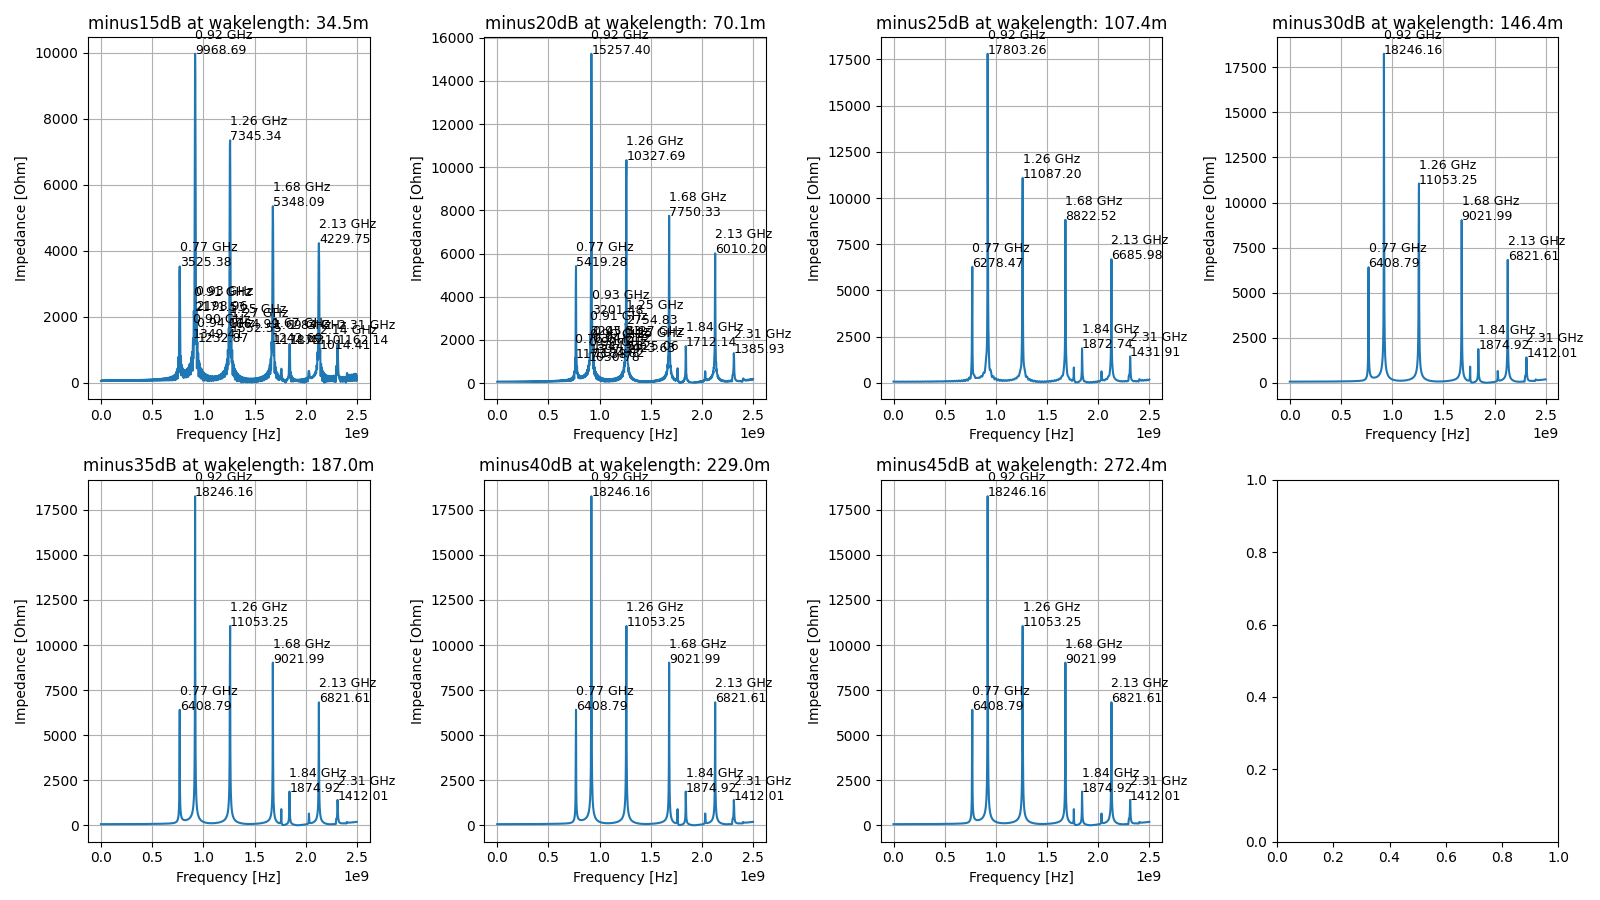

In [5]:
attenuations = [-15.0, -20.0, -25.0, -30.0, -35.0, -40.0, -45.0]

impedances_attenuations, wake_frequencies, row_indicies = impedance_at_attenuations(attenuations, data_wake, data_energy, peak_threshold=1e3, sigmaz=0.04)

In [6]:
"""Genetic algorithm setup"""

frequency = wake_frequencies # Frequency in Hz

parameterBounds = [(1e3, 20e3), (1, 5e3), (0.76e9, 0.78e9),
                   (1e3, 20e3), (1, 5e3), (0.91e9, 0.93e9),
                   (1e3, 20e3), (1, 5e3), (1.25e9, 1.27e9),
                   (1e3, 20e3), (1, 5e3), (1.67e9, 1.69e9),
                   (1e3, 20e3), (1, 5e3), (1.83e9, 1.85e9),
                   (1e3, 20e3), (1, 5e3), (2.12e9, 2.14e9),
                   (1e3, 20e3), (1, 5e3), (2.30e9, 2.32e9)]

Nres = 7

print(parameterBounds)


[(1000.0, 20000.0), (1, 5000.0), (760000000.0, 780000000.0), (1000.0, 20000.0), (1, 5000.0), (910000000.0, 930000000.0), (1000.0, 20000.0), (1, 5000.0), (1250000000.0, 1270000000.0), (1000.0, 20000.0), (1, 5000.0), (1670000000.0, 1690000000.0), (1000.0, 20000.0), (1, 5000.0), (1830000000.0, 1850000000.0), (1000.0, 20000.0), (1, 5000.0), (2120000000.0, 2140000000.0), (1000.0, 20000.0), (1, 5000.0), (2300000000.0, 2320000000.0)]


In [ ]:

"""Run genetic algorithms for all attenuations"""
results = run_genetic_algoritms(impedances_attenuations, row_indicies, frequency, data_wake, time, wake, Nres, parameterBounds, maxiter=1000 tol=0.1)

for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)


Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        5.39e+03        |      486.96      |    7.720e+08     
    2     |        1.45e+04        |      313.36      |    9.195e+08     
    3     |        1.73e+04        |      937.19      |    1.259e+09     
    4     |        1.99e+04        |     2041.42      |    1.677e+09     
    5     |        9.95e+03        |     2941.78      |    1.842e+09     
    6     |        1.78e+04        |     3243.49      |    2.125e+09     
    7     |        1.32e+03        |     3377.42      |    2.318e+09     
----------------------------------------------------------------------
Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |      

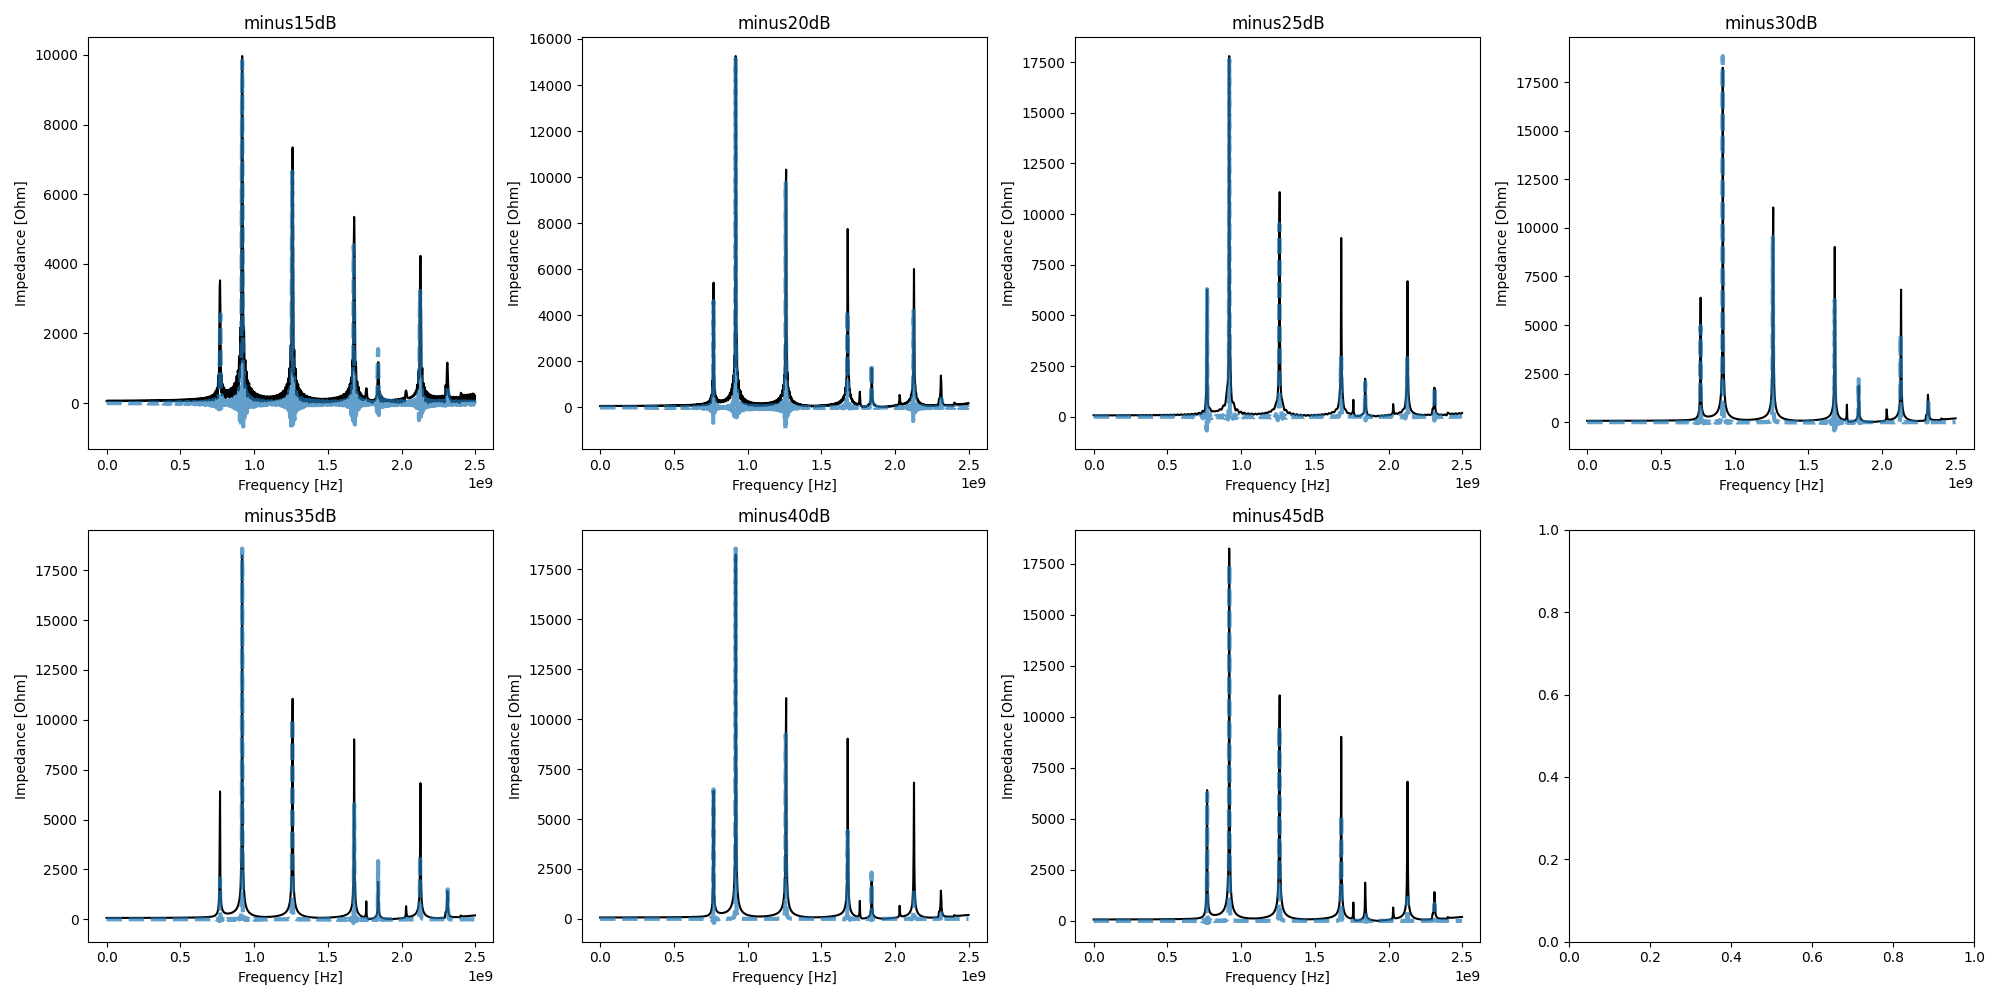

In [10]:
plot_GA_results(results)

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


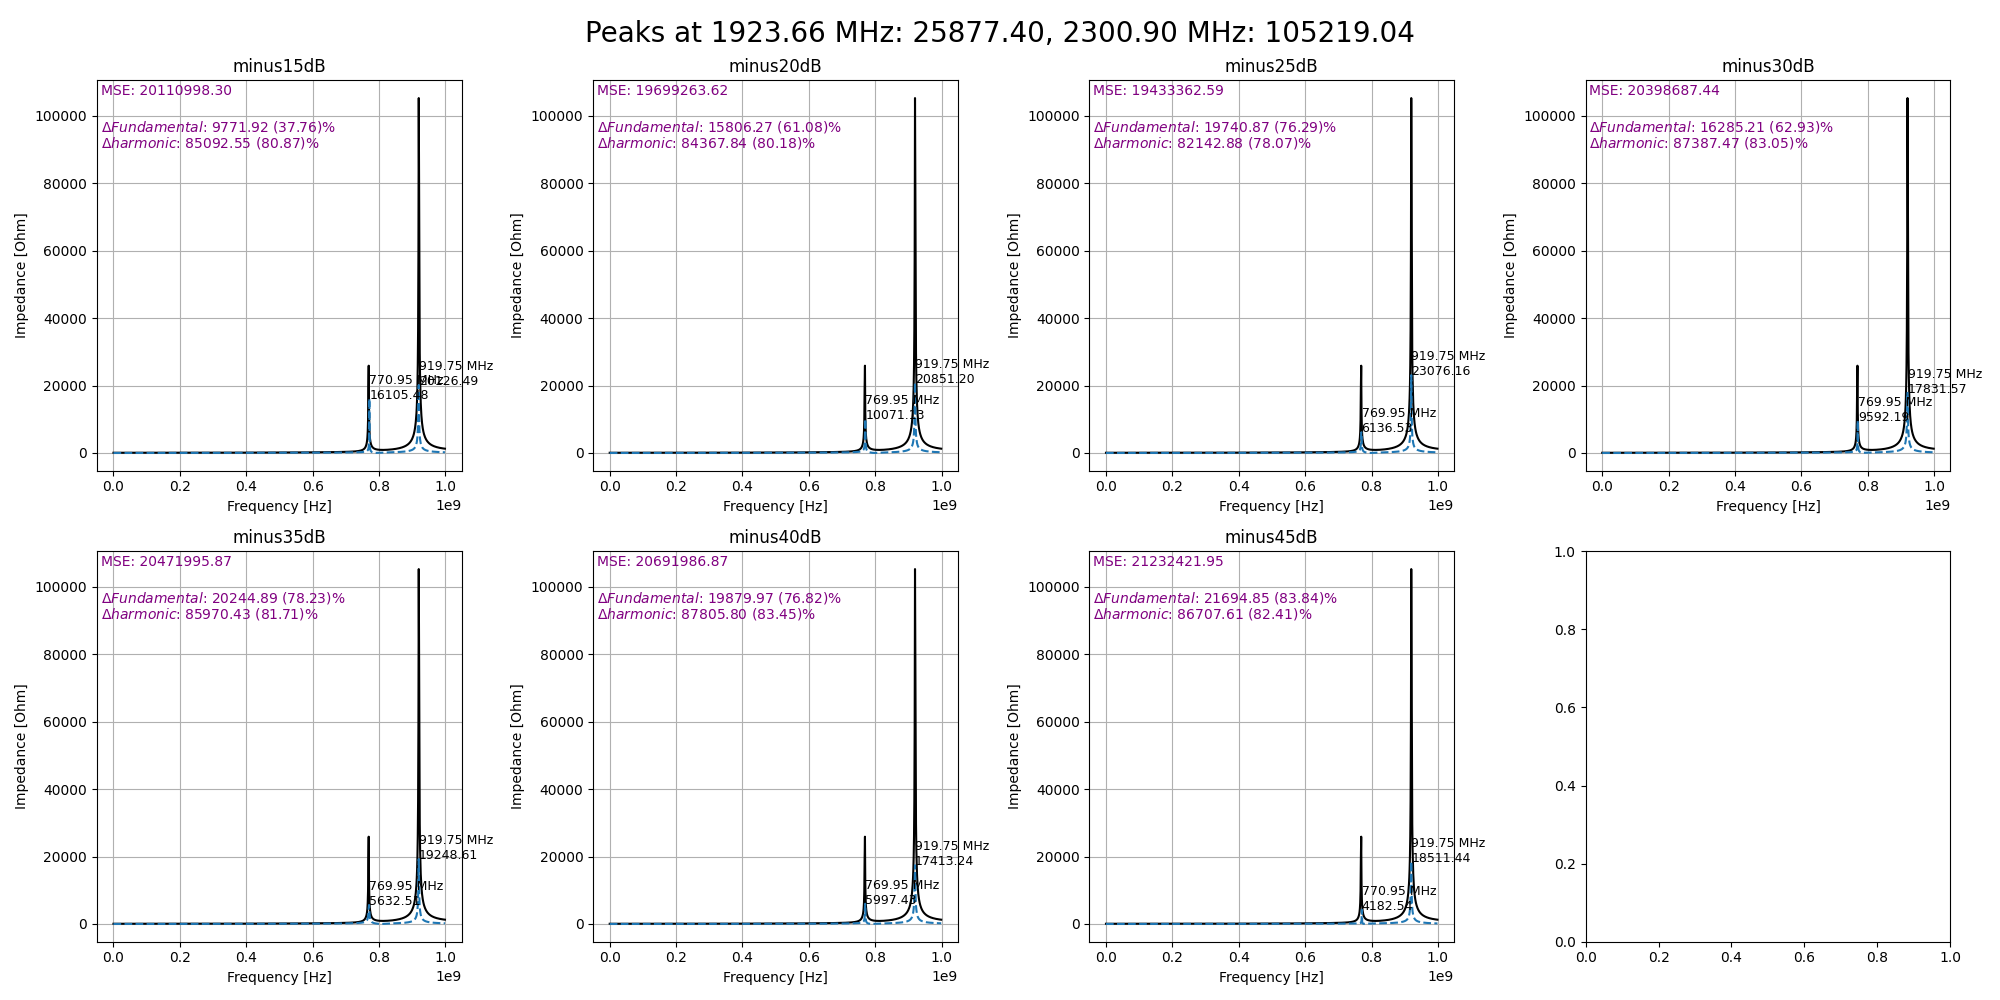

In [22]:
"""Extrapolating the wake until fully decayed"""

end_time = (data_wake[-1, 0]/100)/c_light # Converting from wake length to time. 

new_time_extrapolate = timeframe_for_extrapolation(results, end_time)


"""Compute the longitudinal wake function of the two resonators for all attenuations"""

wake_extrapolations = compute_longitudinal_wake_function(results, new_time_extrapolate)

"""Compute the impedance of the fully decayed simulated data in order to compare it with the extrapolated data"""

wake_fully_simulated, peaks_fs, peaks_height_fs = compute_impedance_wakis(data_wake)

# Comparing the extrapolated wake with the fully simulated data

compare_extrapolation_results(wake_frequencies, wake_extrapolations, new_time_extrapolate, data_wake, charge_dist, wake_fully_simulated, peaks_fs, peaks_height_fs)

In [3]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/cond_1e3p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/STEPOUT/cond_1e3energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


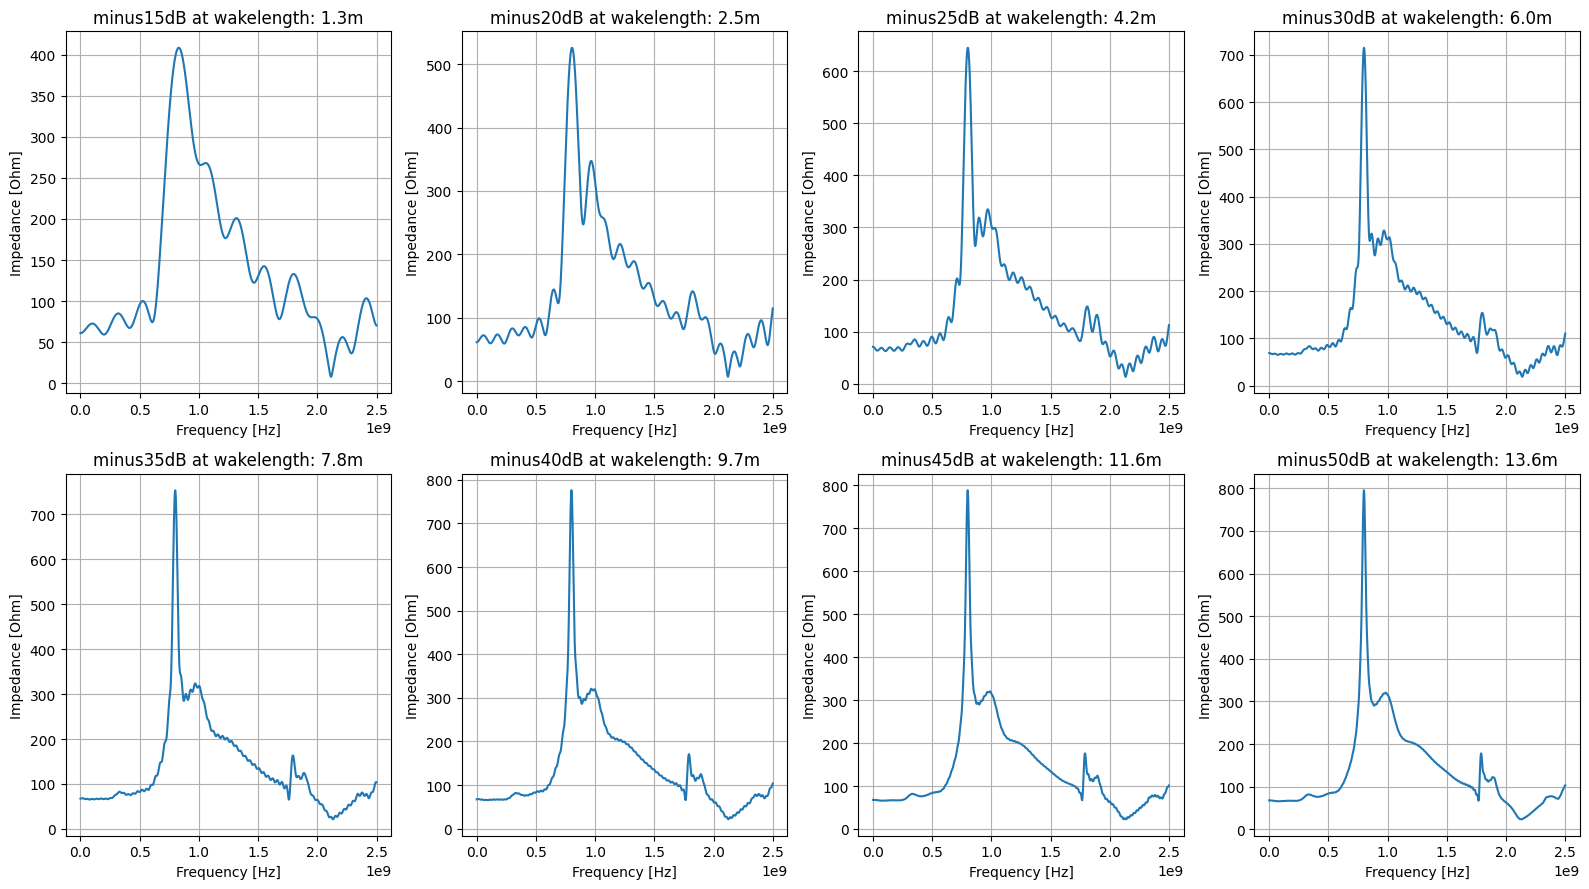

In [4]:
attenuations = [-15.0, -20.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0]

impedances_attenuations, wake_frequencies, row_indicies = impedance_at_attenuations(attenuations, data_wake, data_energy, peak_threshold=1e3)

Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.15e+01        |      456.67      |    3.384e+08     
    2     |        5.53e+02        |      21.83       |    8.405e+08     
    3     |        2.48e+02        |       3.31       |    9.911e+08     
    4     |        5.19e+01        |      950.27      |    1.784e+09     
    5     |        1.55e+02        |      648.23      |    1.936e+09     
----------------------------------------------------------------------
Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        5.70e+01        |      828

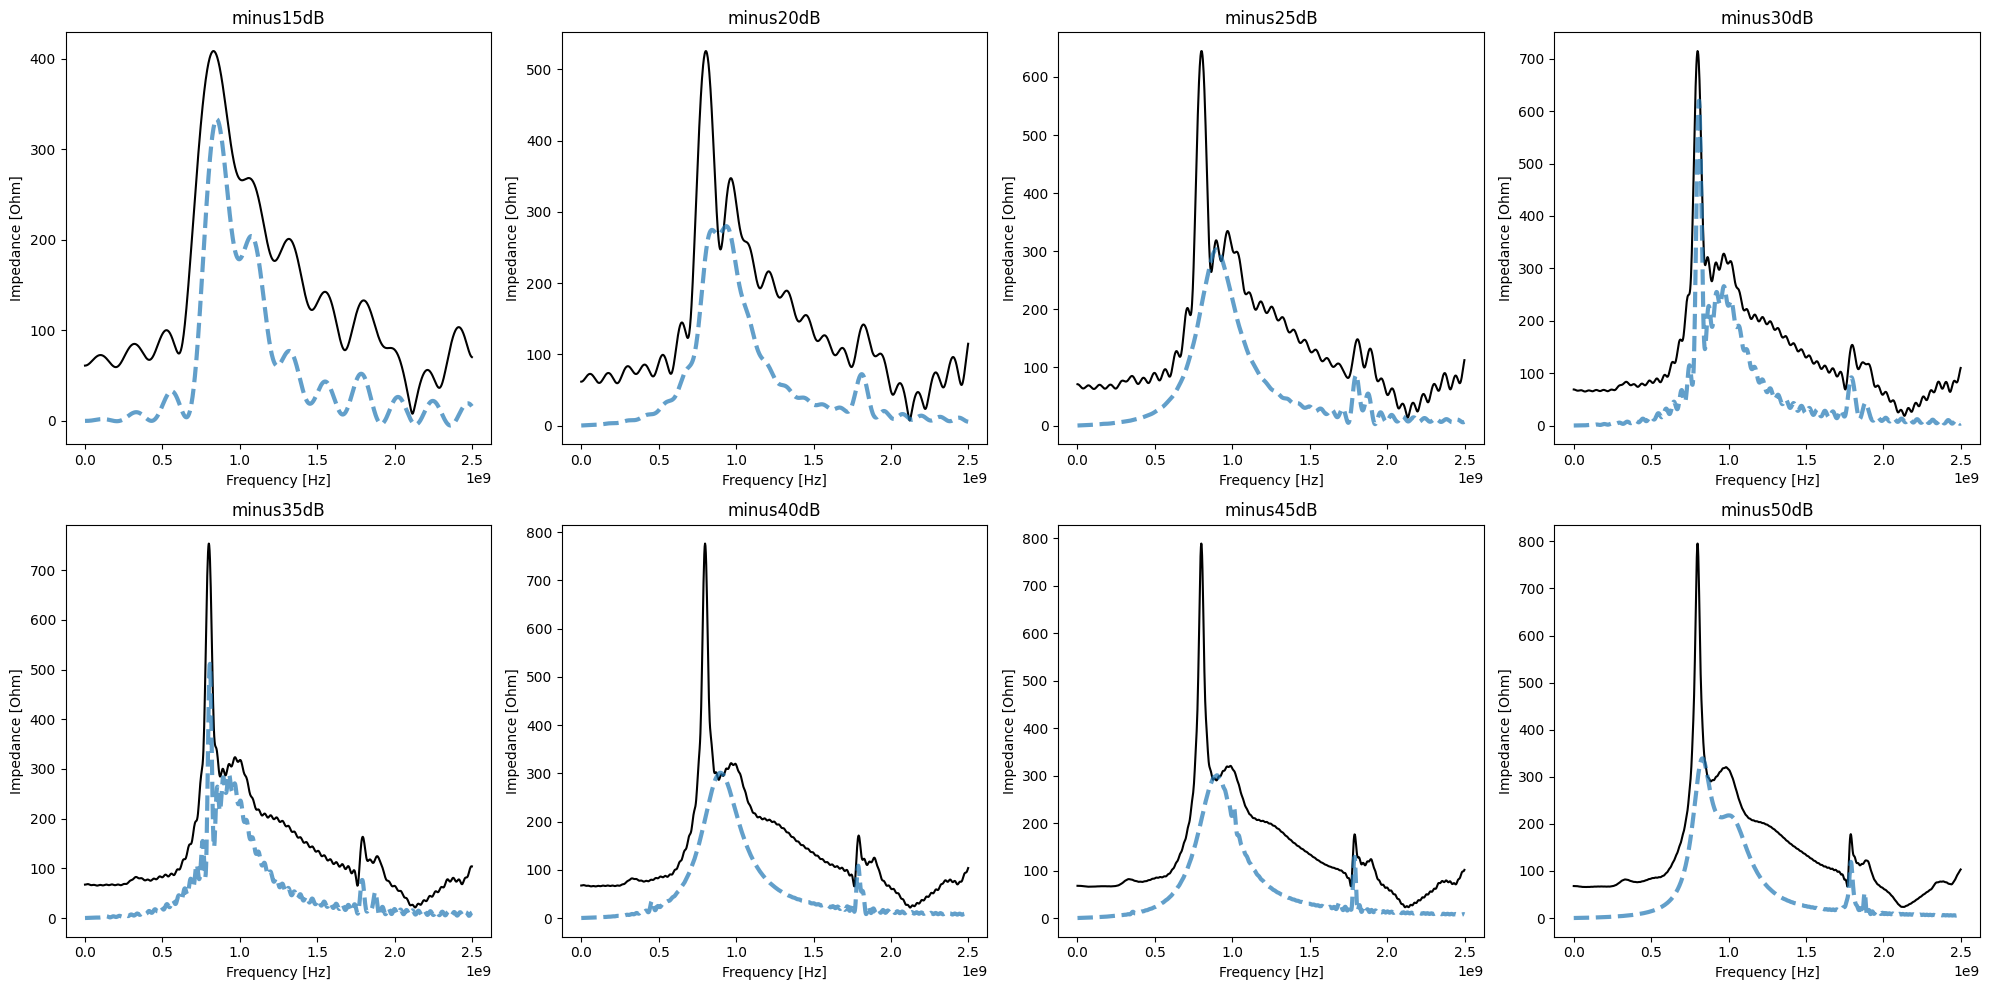

In [5]:
"""Genetic algorithm setup"""

frequency = wake_frequencies # Frequency in Hz

Nres = 5

parameterBounds = [(10, 200), (1, 1e3), (0.2e9, 0.5e9),
          (200, 900), (1, 1e3), (0.7e9, 0.9e9),
          (100, 400), (1, 1e3), (0.9e9, 1.1e9),
          (50, 250), (1, 1e3), (1.7e9, 1.85e9),
          (50, 200), (1, 1e3), (1.85e9, 1.95e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].

"""Run genetic algorithms for all attenuations"""

results = run_genetic_algoritms(impedances_attenuations, row_indicies, frequency, data_wake, time, wake, Nres, parameterBounds)

for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

plot_GA_results(results)